# <center> Исследование базы данных сервиса Stackoverflow
<center> Автор материала: Толстошеева Татьяна (@tsheeva)

Нам нужно написать несколько SQL-запросов в Jupyter Notebook. Необходимые данные находятся в таблицах схемы stackoverflow, подключаемся к базе с помощью SQLAlchemy.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine 
from plotly import graph_objects as go 
import plotly.express as px

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`, с которой вы будете работать в проекте

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

In [4]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

In [6]:
query = '''
SELECT DATE_TRUNC('month', creation_date):: date month_date,
       SUM(views_count) total_views
FROM stackoverflow.posts
WHERE EXTRACT(YEAR FROM CAST(creation_date AS timestamp)) = 2008
GROUP BY 1
ORDER BY 2 DESC
'''

sample_df = pd.read_sql_query(query, con=engine) 
sample_df

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


В таблице с общей суммой просмотров постов за каждый месяц 2008 года не хватает данных за первое полугодие, а в июле количество просмотров анамально низкое. Возможно, это связано с тем, что запись ведется с конца июля.

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

In [7]:
query = '''
SELECT display_name,
       COUNT(DISTINCT user_id)
FROM stackoverflow.users u
JOIN stackoverflow.posts p ON p.user_id=u.id
JOIN stackoverflow.post_types pt ON p.post_type_id=pt.id
WHERE pt.type='Answer'
  AND p.creation_date BETWEEN u.creation_date AND u.creation_date::timestamp + interval '1 month'
GROUP BY 1
HAVING COUNT(p.id)>100
ORDER BY 1

'''

df = pd.read_sql_query(query, con=engine) 
df

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
71,leppie,1
72,lomaxx,1
73,mattlant,1
74,paxdiablo,1


Мы видим, что под одним именем могут быть зарегистрировано несколько пользователей. 

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

In [8]:
query = '''
WITH users_list AS
    (SELECT DISTINCT p.user_id
    FROM stackoverflow.posts p
    JOIN stackoverflow.users u ON p.user_id=u.id
    WHERE DATE_TRUNC('month', u.creation_date) :: date = '2008-09-01'
    AND DATE_TRUNC('month', p.creation_date) :: date = '2008-12-01')
SELECT DATE_TRUNC('month', posts.creation_date):: date AS month,
        COUNT(posts.id)
FROM stackoverflow.posts 
JOIN users_list ul ON posts.user_id = ul.user_id
GROUP BY 1
ORDER BY 1 DESC
'''

df = pd.read_sql_query(query, con=engine) 
df

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


В августе было опубликовано 32 поста пользователями, которые зарегистрировались только в сентябре. Возможно это ошибка на стороне сервиса или при редактировании профиля меняется и 'creation_date' в таблице 'users'.

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

In [9]:
query = '''
SELECT user_id,
        creation_date,
        views_count,
        SUM(views_count) OVER (PARTITION BY user_id ORDER BY creation_date) AS cumulative_cum
FROM stackoverflow.posts
ORDER BY 1,
         2
'''

df = pd.read_sql_query(query, con=engine) 
df

,user_id,creation_date,views_count,cumulative_cum
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

In [10]:
query = '''
WITH posts_table AS
    (SELECT DISTINCT user_id,
            DATE_TRUNC('day', creation_date ) :: date AS dt,
            COUNT(*) OVER (PARTITION BY user_id, DATE_TRUNC('day', creation_date ) :: date)
    FROM stackoverflow.posts
    WHERE DATE_TRUNC('month', creation_date) :: date = '2008-08-01'
      AND user_id IN (SELECT user_id
                        FROM stackoverflow.posts
                        WHERE DATE_TRUNC('month', creation_date) :: date = '2008-08-01'
                        GROUP BY user_id
                        HAVING COUNT(id) > 120))
SELECT user_id,
       AVG(count)
FROM posts_table
GROUP BY 1
ORDER BY 2
'''

df = pd.read_sql_query(query, con=engine) 
df

,user_id,avg
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

In [11]:
query = '''
WITH active_days as
    (SELECT user_id,
           COUNT(DISTINCT DATE_TRUNC('day', creation_date) :: date)
    FROM stackoverflow.posts
    WHERE CAST(creation_date AS date) BETWEEN '2008-12-01' AND '2008-12-07'
    GROUP BY 1)
SELECT ROUND(AVG(count))
FROM active_days
'''

df = pd.read_sql_query(query, con=engine) 
df

,round
0,2.0


За первые 7 дней декабря 2008 года пользователи в среднем взаимодействовали с платформой 2 дня.

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

In [12]:
query = '''
SELECT user_id,
       creation_date,
       TO_CHAR(LAG(creation_date, 2) OVER (ORDER BY user_id, creation_date), 'Month')
FROM stackoverflow.posts
ORDER BY 1,
         2
'''

df = pd.read_sql_query(query, con=engine) 
df

,user_id,creation_date,to_char
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

In [13]:
query = '''
WITH profile AS
    (WITH cohort_dt AS
        (SELECT DISTINCT user_id,
                        MIN(DATE_TRUNC('month', creation_date):: date) OVER (PARTITION BY user_id) AS cohort_dt
        FROM stackoverflow.posts)
    SELECT user_id,
           cohort_dt,
           COUNT(*) OVER (PARTITION BY cohort_dt) AS cohort_users_cnt
    FROM cohort_dt),
sessions AS
    (SELECT user_id,
           DATE_TRUNC('month', creation_date) :: date AS session_date
    FROM stackoverflow.posts
    GROUP BY 1,
             2
    ORDER BY 1,
             2)
SELECT p.cohort_dt,
       s.session_date,
       COUNT(p.user_id) AS users_cnt,
       cohort_users_cnt,
       ROUND(COUNT(p.user_id) *100.0 / cohort_users_cnt, 2) AS retention_rate
FROM profile p JOIN sessions s ON p.user_id = s.user_id
GROUP BY 1,
         2,
         4
'''

df = pd.read_sql_query(query, con=engine) 
retention_rate_df = pd.read_sql_query(query, con = engine) 
retention_rate_df

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


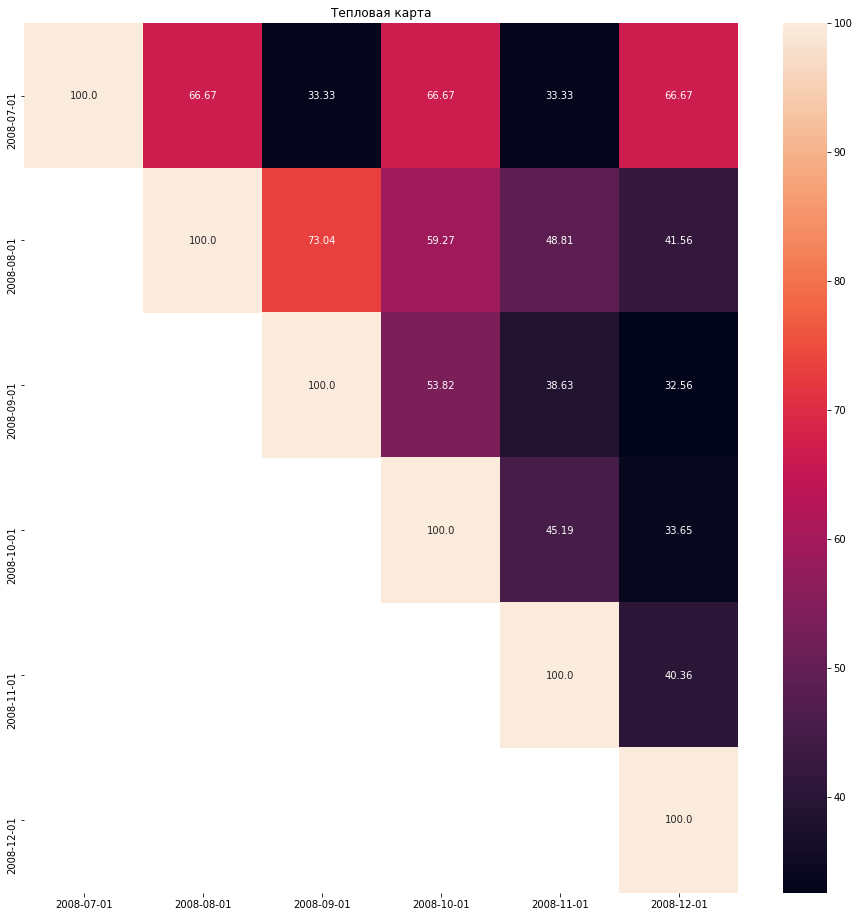

In [14]:
# строим тепловую карту Retention Rate
retention = retention_rate_df.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

plt.figure(figsize=(16, 16)) # задаём размер графика
sns.heatmap(retention, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show() 

1. В июльскую когорту попало всего 3 человека, поэтому пост одного человека так сильно влияет на коофицент Retention Rate. 
2. В когорте пользователей от августа самый большой коэффициент удержания первого месяца по сравнению с другими когортами. Самый низкий - от ноября. 
3. С каждым месяцем динамика Retention Rate все хуже и хуже. 

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Округлите значение процента до двух знаков после запятой.

In [15]:
query = '''
WITH month_count AS
    (SELECT EXTRACT(MONTH FROM creation_date) creation_month,
           COUNT(*) posts_count
    FROM stackoverflow.posts
    WHERE CAST(creation_date AS date) BETWEEN '2008-09-01' AND '2008-12-31'
    GROUP BY 1)
SELECT *,
       ROUND(((posts_count::numeric / LAG(posts_count) OVER (ORDER BY creation_month)) -1 ) * 100, 2) AS percentage
FROM month_count

'''

df = pd.read_sql_query(query, con=engine) 
df

,creation_month,posts_count,percentage
0,9.0,70371,NaN
1,10.0,63102,-10.33
2,11.0,46975,-25.56
3,12.0,44592,-5.07


# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

In [17]:
query = '''
SELECT EXTRACT(WEEK FROM CAST(creation_date AS timestamp)) week_creation,
       MAX(creation_date) 
FROM stackoverflow.posts
WHERE EXTRACT(MONTH FROM CAST(creation_date AS timestamp)) = 10 
  AND user_id IN (WITH user_count AS
                    (SELECT user_id,
                           COUNT(id)
                    FROM stackoverflow.posts
                    GROUP BY 1
                    ORDER BY 2 DESC)
                SELECT user_id
                FROM user_count
                LIMIT 1)
GROUP BY 1
'''

df = pd.read_sql_query(query, con=engine) 
df

,week_creation,max
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01
